# 1. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
import time
from pathlib import Path

from openml import tasks, datasets

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,recall_score,ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold,RandomizedSearchCV,train_test_split
from sklearn import svm
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

from xgboost import XGBClassifier

# 2. Load datasets

In [25]:
def load_dataset(dataset_source):

    if dataset_source =="HTRU":

        '''
        Orginal data from High Time Resolution Universe (HTRU) 
        Dataset: https://www.openml.org/search?type=data&status=active&id=45558&sort=runs
        ''' 

        # Load the dataset from OpenML
        htru2_dataset = datasets.get_dataset(45558,download_data=False,download_qualities=False,download_features_meta_data=False)
        X, y, _, _ = htru2_dataset.get_data(dataset_format='dataframe', target=htru2_dataset.default_target_attribute)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Split the data into train and temporary test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Split the train and validation sets from the temporary train set
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

        # Store original column names
        input_columns = X_train.columns

        print("Training Set Shape: ",X_train.shape)
        print("Validation Set Shape: ",X_valid.shape)
        print("Testing Set Shape: ",X_test.shape)
        
        y_train= y_train.to_numpy()
        y_test= y_test.to_numpy()
        y_valid= y_valid.to_numpy()


        X_train.head()

    else:
        # Load the dataset from CSV file
        
        '''
        Data from LOFAR Tied-Array All-Sky Survey (LOTAAS)
        
        Paper: The LOFAR Tied-Array All-Sky Survey (LOTAAS): Survey overview and initial pulsar discoveries
        Sanidas et. al. 
        
        Catalogue: https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=J/A+A/626/A104&-to=3#tablist
        '''

        dataset_filename = "LOTAAS_1_Lyon_Features (8).csv"
        #dataset_filename = "LOTAAS_1_Lyon_Features (8)_10_Bin_Discretized.csv"

        data = pd.read_csv(dataset_filename, header=None, names=['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'class'])

        # Split the  data into features (X) and target (y)
        X = data.iloc[:, :-1].values  # Select all rows and columns except the last column
        y = data.iloc[:, -1].values   # Select all rows and the last column

        # Split the data into train and temporary test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Split the train and validation sets from the temporary train set
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

        input_columns = data.columns[:-1]
        output_columns = data.columns[-1]

        X_train= pd.DataFrame(X_train)
        X_valid= pd.DataFrame(X_valid)
        X_test = pd.DataFrame(X_test)

        print("Training Set Shape: ",X_train.shape)
        print("Validation Set Shape: ",X_valid.shape)
        print("Testing Set Shape: ",X_test.shape)

        X_train.columns = input_columns
        X_valid.columns = input_columns
        X_test.columns = input_columns

        X_train.head()
        
    return X_train, X_valid, X_test, y_train, y_valid, y_test, input_columns


# 3. Preprocess Data

In [26]:
def preprocess_data(X_train, X_valid, X_test, input_columns):
    
    # Normalize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)
    
    # Imputer
    imputer= SimpleImputer(strategy='median')
    imputer.fit(X_train)

    X_train_imputed= pd.DataFrame(imputer.transform(X_train))
    X_valid_imputed= pd.DataFrame(imputer.transform(X_valid))
    X_test_imputed = pd.DataFrame(imputer.transform(X_test))

    # Assign original column names back to the DataFrames
    X_train_imputed.columns = input_columns
    X_valid_imputed.columns = input_columns
    X_test_imputed.columns = input_columns

    return X_train_imputed,X_valid_imputed,X_test_imputed

In [29]:
dataset_source = "HTRU"
#dataset_source ="LOTAAS"

X_train, X_valid, X_test, y_train, y_valid, y_test, input_columns = load_dataset(dataset_source)


X_train,X_valid,X_test= preprocess_data(X_train,X_valid,X_test,input_columns)

y_train= [int(x) for x in y_train]
y_test= [int(x) for x in y_test]
y_valid= [int(x) for x in y_valid]

X_train.head()

Training Set Shape:  (10022, 8)
Validation Set Shape:  (4296, 8)
Testing Set Shape:  (3580, 8)


,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis
0,0.198527,-0.254488,-0.079679,-0.220560,-0.399671,-0.726701,1.961274,1.912113
1,-1.348457,-0.220582,1.163613,0.222000,2.943955,3.603416,-1.823941,-0.999158
2,0.351733,0.580177,-0.353943,-0.327688,-0.336761,-0.315668,-0.064086,-0.355104
3,-0.154486,0.326579,-0.247304,-0.320839,-0.108577,0.452900,-0.961519,-0.833733
4,-0.636034,-0.242597,0.144452,-0.231498,-0.348985,-0.278374,0.290662,-0.095560


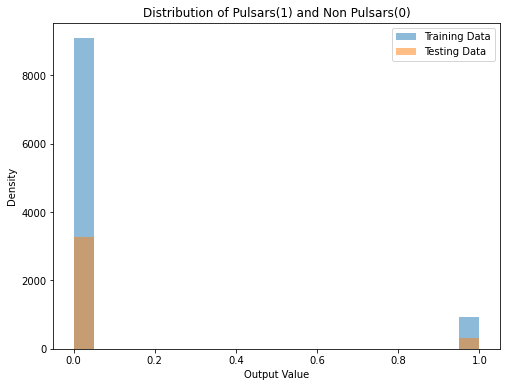

In [5]:
# Plot the distributions
plt.figure(figsize=(8, 6))
plt.hist(y_train, bins=20, alpha=0.5, label='Training Data')
plt.hist(y_test, bins=20, alpha=0.5, label='Testing Data')
plt.title('Distribution of Pulsars(1) and Non Pulsars(0)')
plt.xlabel('Output Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# 4. RandomForestClassifier

In [6]:
def rfc(X_train, y_train, X_test, y_test):
    
    # Define model
    model_rfc = RandomForestClassifier(n_estimators=30, random_state=0)


    model_rfc.fit(X_train, y_train)
    y_pred_rfc = model_rfc.predict(X_test)

    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=1)
    # evaluate model
    scores = cross_val_score(model_rfc, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
    # summarize performance
    print('Mean Accuracy: %.3f' % np.mean(scores))
    
    accuracy = accuracy_score(y_test, y_pred_rfc)
    precision = precision_score(y_test, y_pred_rfc)
    recall = recall_score(y_test, y_pred_rfc)

    print(f"Accuracy using RandomForestClassifier: %.3f"%accuracy)
    print(f"Precision using RandomForestClassifier: %.3f"%precision)
    print("Recall using RandomForestClassifier: %.3f" %recall)

In [7]:
rfc(X_train, y_train, X_test, y_test)

Mean Accuracy: 0.980
Accuracy using RandomForestClassifier: 0.980
Precision using RandomForestClassifier: 0.934
Recall using RandomForestClassifier: 0.838


## 5.1 Random Forest With Bootstrap Class Weighting



In [8]:
def rfc_with_bootstrap(X_train, y_train, X_test, y_test):
    
    model_rfc_bcw = RandomForestClassifier(n_estimators=30,random_state=0,class_weight='balanced_subsample')
    model_rfc_bcw.fit(X_train, y_train)
    y_pred_rfc_bcw = model_rfc_bcw.predict(X_test)
    
    accuracy_rfc_bcw = accuracy_score(y_test, y_pred_rfc_bcw)
    precision_rfc_bcw = precision_score(y_test, y_pred_rfc_bcw)
    recall_rfc_bcw = recall_score(y_test, y_pred_rfc_bcw)
        
    print(f"Accuracy using Bootstrap Class Weighting: %.3f"%accuracy_rfc_bcw)
    print(f"Precision using Bootstrap Class Weighting: %.3f"%precision_rfc_bcw)
    print("Recall using Bootstrap Class Weighting: %.3f" %recall_rfc_bcw)

In [9]:
rfc_with_bootstrap(X_train, y_train, X_test, y_test)

Accuracy using Bootstrap Class Weighting: 0.981
Precision using Bootstrap Class Weighting: 0.941
Recall using Bootstrap Class Weighting: 0.841


## 6. Using XGBoost


In [10]:
def xgb_classifier(X_train, y_train, X_test, y_test):

    # XGBoost on the Training set

    '''
    https://stackoverflow.com/questions/71996617/invalid-classes-inferred-from-unique-values-of-y-expected-0-1-2-3-4-5-got
    '''
    le = LabelEncoder()
    y_train_xgb = le.fit_transform(y_train)

    xgb_classifier = XGBClassifier()
    xgb_classifier.fit(X_train, y_train_xgb)

    y_pred_xgb = xgb_classifier.predict(X_test)
    y_pred_xgb = le.inverse_transform(y_pred_xgb)
    
    accuracy_score_xgb= accuracy_score(y_test, y_pred_xgb)    
    print(f"Accuracy Score using XGB: %.3f"%accuracy_score_xgb)

    cm = confusion_matrix(y_test, y_pred_xgb)
    
    classes= np.unique(y_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()

Accuracy Score using XGB: 0.982


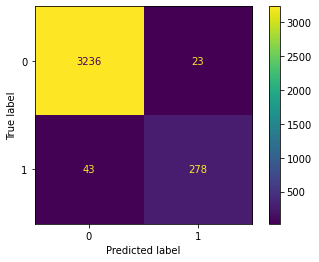

In [11]:
xgb_classifier(X_train, y_train, X_test, y_test)

## 7. Using Bagging Classifier

We are dealing with imbalanced classification problem so can't use usual ML models without accounting for dataset class imbalance. Here I use bagging classifier as first approach to deal with thhat problem.

https://www.datacamp.com/tutorial/what-bagging-in-machine-learning-a-guide-with-examples

1. Bagging classifier is an ensemble classifier which is created using multiple estimators which can be trained using different sampling techniques including bagging or bootstrap aggregation (samples drawn with replacement). 

2. Bagging classifier helps reduce the variance of individual estimators by sampling technique and combining the predictions.


In [12]:
def bagging_classifier(X_train, y_train, X_test, y_test):
    
    # deafault base estimator is a DecisionTreeClassifier.

    bagging = BaggingClassifier(n_estimators=10, random_state=0)
    bagging.fit(X_train, y_train)

    y_pred_bagging = bagging.predict(X_test)

    accuracy_bag = accuracy_score(y_test, y_pred_bagging)
    precision_bag = precision_score(y_test, y_pred_bagging)
    recall_bag = recall_score(y_test, y_pred_bagging)
    
    print(f"Accuracy Score using Bagging Classifier: %.3f"%accuracy_bag)
    print(f"Precision Score using Bagging Classifier: %.3f"%precision_bag)
    print(f"Recall Score using Bagging Classifier: %.3f"%recall_bag)

    # Model scores on test and training data
    print('Model training Score: %.3f' %bagging.score(X_train, y_train))
    print('Model test Score: %.3f ' %bagging.score(X_test, y_test))

In [13]:
bagging_classifier(X_train, y_train, X_test, y_test)

Accuracy Score using Bagging Classifier: 0.978
Precision Score using Bagging Classifier: 0.921
Recall Score using Bagging Classifier: 0.832
Model training Score: 0.998
Model test Score: 0.978 


# 7.1 Bagging with Random Forest Classifier as Base Estimator


In [14]:
def bagging_classifier_rgb(X_train, y_train, X_test, y_test):
    rfc_bagging = BaggingClassifier(base_estimator=RandomForestClassifier(),n_estimators=10, random_state=0)
    rfc_bagging.fit(X_train, y_train)

    y_pred_rfc_bagging = rfc_bagging.predict(X_test)

    accuracy_bag_rfc = accuracy_score(y_test, y_pred_rfc_bagging)
    precision_bag_rfc = precision_score(y_test, y_pred_rfc_bagging)
    recall_bag_rfc= recall_score(y_test, y_pred_rfc_bagging)

    print(f"Accuracy Score using Bagging Classifier with RFC: %.3f"%accuracy_bag_rfc)
    print(f"Precision Score using Bagging Classifier with RFC: %.3f"%precision_bag_rfc)
    print(f"Recall Score using Bagging Classifier with RFC: %.3f"%recall_bag_rfc)

    # Model scores on test and training data
    print('Model training Score: %.3f' %rfc_bagging.score(X_train, y_train))
    print('Model test Score: %.3f ' %rfc_bagging.score(X_test, y_test))


In [15]:
bagging_classifier_rgb(X_train, y_train, X_test, y_test)

Accuracy Score using Bagging Classifier with RFC: 0.980
Precision Score using Bagging Classifier with RFC: 0.931
Recall Score using Bagging Classifier with RFC: 0.844
Model training Score: 0.991
Model test Score: 0.980 


# 7.2 Bagging with Support Vector Classifier as Base Estimator

In [16]:
def bagging_classifier_svc(X_train, y_train, X_test, y_test):
    
    #First just fit data using classic SVC for test purpose 
    model_svc = svm.SVC()

    model_svc.fit(X_train, y_train)

    y_pred_svc = model_svc.predict(X_test)

    accuracy_svc = accuracy_score(y_test, y_pred_svc)
    precision_svc = precision_score(y_test, y_pred_svc)
    recall_svc = recall_score(y_test, y_pred_svc)

    print(f"Accuracy Score using SVC: %.3f"%accuracy_svc)
    print(f"Precision Score using SVC: %.3f"%precision_svc)
    print(f"Recall Score using SVC: %.3f"%precision_svc)
    
    # Now using bagging classfier
    svc_bagging = BaggingClassifier(base_estimator=svm.SVC(),n_estimators=10, random_state=0)
    svc_bagging.fit(X_train, y_train)

    y_pred_svc_bagging = svc_bagging.predict(X_test)

    accuracy_bag_svc = accuracy_score(y_test, y_pred_svc_bagging)
    precision_bag_svc = precision_score(y_test, y_pred_svc_bagging)
    recall_bag_svc = recall_score(y_test, y_pred_svc_bagging)

    print(f"Accuracy Score using Bagging Classifier with SVC: %.3f"%accuracy_bag_svc)
    print(f"Precision Score using Bagging Classifier with SVC: %.3f"%precision_bag_svc)
    print(f"Recall Score using Bagging Classifier with SVC: %.3f"%recall_bag_svc)
    
    print('Model training Score: %.3f' %svc_bagging.score(X_train, y_train))
    print('Model test Score: %.3f ' %svc_bagging.score(X_test, y_test))

In [17]:
bagging_classifier_svc(X_train, y_train, X_test, y_test)

Accuracy Score using SVC: 0.980
Precision Score using SVC: 0.943
Recall Score using SVC: 0.943
Accuracy Score using Bagging Classifier with SVC: 0.980
Precision Score using Bagging Classifier with SVC: 0.940
Recall Score using Bagging Classifier with SVC: 0.829
Model training Score: 0.979
Model test Score: 0.980 
